In [1]:
!pip install moviepy --upgrade
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: moviepy
    Found existing installation: moviepy 1.0.3
    Uninstalling moviepy-1.0.3:
      Successfully uninstalled moviepy-1.0.3


In [2]:
from pathlib import Path
from typing import List, Tuple, Sequence

import numpy as np
from numpy import unravel_index
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm, notebook

from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

import math
from scipy.ndimage import gaussian_filter

import gc
import time
import random
import csv

In [3]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import gdown

In [4]:
def get_num_clips(path: Path, game: int) -> int:
    return len(list((path / f'game{game}/').iterdir()))


def get_game_clip_pairs(path: Path, games: List[int]) -> List[Tuple[int, int]]:
    return [(game, c)  for game in games for c in range(1, get_num_clips(path, game) + 1)]


def load_clip_data(path: Path, game: int, clip: int, downscale: bool, quiet=False) -> np.ndarray:
    if not quiet:
        suffix = 'downscaled' if downscale else ''
        print(f'loading clip data (game {game}, clip {clip}) {suffix}')
    cache_path = path / 'cache'
    cache_path.mkdir(exist_ok=True)
    resize_code = '_ds2' if downscale else ''
    cached_data_name = f'{game}_{clip}{resize_code}.npz'
    if (cache_path / cached_data_name).exists():
        clip_data = np.load(cache_path / cached_data_name)['clip_data']
    else:
        clip_path = path / f'game{game}/clip{clip}'
        n_imgs = len(list(clip_path.iterdir())) - 1
        imgs = [None] * n_imgs
        for i in notebook.tqdm(range(n_imgs)):
            img = Image.open(clip_path / f'{i:04d}.jpg')
            if downscale:
                img = img.resize((img.width // 2, img.height // 2),)
            imgs[i] = np.array(img, dtype=np.uint8)
        clip_data = np.stack(imgs)
        cache_path.mkdir(exist_ok=True, parents=True)
        np.savez_compressed(cache_path / cached_data_name, clip_data=clip_data)
    return clip_data


def load_clip_labels(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    if not quiet:
        print(f'loading clip labels (game {game}, clip {clip})')
    clip_path = path / f'game{game}/clip{clip}'
    labels = []
    with open(clip_path / 'labels.csv') as csvfile:
        lines = list(csv.reader(csvfile))
        for line in lines[1:]:
            values = np.array([-1 if i == '' else int(i) for i in line[1:]])
            if downscale:
                values[1] //= 2
                values[2] //= 2
            labels.append(values)
    return np.stack(labels)


def load_clip(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    data = load_clip_data(path, game, clip, downscale, quiet)
    labels = load_clip_labels(path, game, clip, downscale, quiet)
    return data, labels

In [5]:
def prepare_experiment(out_path: Path) -> Path:
    out_path.mkdir(parents=True, exist_ok=True)
    dirs = [d for d in out_path.iterdir() if d.is_dir() and d.name.startswith('exp_')]
    experiment_id = max(int(d.name.split('_')[1]) for d in dirs) + 1 if dirs else 1
    exp_path = out_path / f'exp_{experiment_id}'
    exp_path.mkdir()
    return exp_path


def ball_gauss_template(rad, sigma):
    x, y = np.meshgrid(np.linspace(-rad, rad, 2 * rad + 1), np.linspace(-rad, rad, 2 * rad + 1)) 
    dst = np.sqrt(x * x + y * y) 
    gauss = np.exp(-(dst ** 2 / (2.0 * sigma ** 2)))     
    return gauss


def create_masks(data: np.ndarray, labels: np.ndarray, resize):
    rad = 64 #25
    sigma = 10
    if resize:
        rad //= 2
    ball = ball_gauss_template(rad, sigma)
    n_frames = data.shape[0]
    sh = rad
    masks = []
    for i in range(n_frames):
        label = labels[i, ...] 
        frame = data[i, ...]
        if 0 < label[0] < 3:
            x, y = label[1:3]
            mask = np.zeros((frame.shape[0] + 2 * rad + 2 * sh, frame.shape[1] + 2 * rad + 2 * sh), np.float32)
            mask[y + sh : y + sh + 2 * rad + 1, x + sh : x + sh + 2 * rad + 1] = ball
            mask = mask[rad + sh : -rad - sh, rad + sh : -rad - sh]
            masks.append(mask)
        else:
            masks.append(np.zeros((frame.shape[0], frame.shape[1]), dtype=np.float32))
    return np.stack(masks)

loading clip data (game 1, clip 1) 
loading clip labels (game 1, clip 1)
[  1 581 286   0]


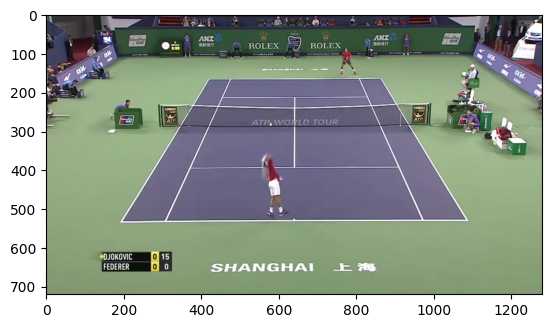

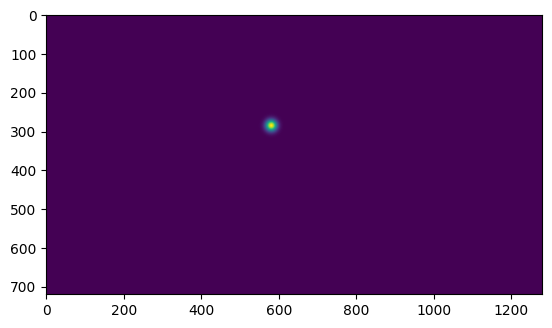

In [6]:
clip, label = load_clip(Path('../input/tennistrackingassignment/train/'), 1, 1, False)
frame, lbl = clip[24], label[24]
plt.figure()
plt.imshow(frame)
print(lbl)

mask = create_masks(np.array([frame]), np.array([lbl]), False)[0]
plt.figure()
plt.imshow(mask)

In [7]:
def _add_frame_number(frame: np.ndarray, number: int) -> np.ndarray:
    fnt = ImageFont.load_default() # ImageFont.truetype("arial.ttf", 25)
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), f'frame {number}', font=fnt, fill=(255, 0, 255))
    return np.array(img)


def _vis_clip(data: np.ndarray, lbls: np.ndarray, metrics: List[float] = None, ball_rad=5, color=(255, 0, 0), track_length=10):
    print('perfoming clip visualization')
    n_frames = data.shape[0]
    frames_res = []
    fnt = ImageFont.load_default() # ImageFont.truetype("arial.ttf", 25)
    for i in range(n_frames):
        img = Image.fromarray(data[i, ...])
        draw = ImageDraw.Draw(img)
        txt = f'frame {i}'
        if metrics is not None:
            txt += f', SiBaTrAcc: {metrics[i]:.3f}'
        draw.text((10, 10), txt, font=fnt, fill=(255, 0, 255))
        label = lbls[i]
        if label[0] != 0: # the ball is clearly visible
            px, py = label[1], label[2]
            draw.ellipse((px - ball_rad, py - ball_rad, px + ball_rad, py + ball_rad), outline=color, width=2)
            for q in range(track_length):
                if lbls[i-q-1][0] == 0:
                    break
                if i - q > 0:
                    draw.line((lbls[i - q - 1][1], lbls[i - q - 1][2], lbls[i - q][1], lbls[i - q][2]), fill=color)                
        frames_res.append(np.array(img))
    return frames_res


def _save_clip(frames: Sequence[np.ndarray], path: Path, fps):
    assert path.suffix in ('.mp4', '.gif')
    clip = ImageSequenceClip(frames, fps=fps)
    if path.suffix == '.mp4':
        clip.write_videofile(str(path), fps=fps, logger=None)
    else:
        clip.write_gif(str(path), fps=fps, logger=None)


def _to_yellow_heatmap(frame: np.ndarray, pred_frame: np.ndarray, alpha=0.4):
    img = Image.fromarray((frame * alpha).astype(np.uint8))
    maskR = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskG = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskB = np.zeros_like(maskG, dtype=np.uint8)
    mask = np.stack([maskR, maskG, maskB], axis=-1)
    return img + mask


def _vis_pred_heatmap(data_full: np.ndarray, pred_prob: np.ndarray, display_frame_number):
    n_frames = data_full.shape[0]
    v_frames = []
    for i in range(n_frames):
        frame = data_full[i, ...]
        pred = pred_prob[i, ...]
        hm = _to_yellow_heatmap(frame, pred)
        if display_frame_number:
            hm = _add_frame_number(hm, i)
        v_frames.append(hm)
    return v_frames


def visualize_prediction(data_full: np.ndarray, labels_pr: np.ndarray, save_path: Path, name: str, metrics=None, fps=15):
    with open(save_path / f'{name}.txt', mode='w') as f:
        if metrics is not None:
            f.write(f'SiBaTrAcc: {metrics[-1]} \n')
        for i in range(labels_pr.shape[0]):
            f.write(f'frame {i}: {labels_pr[i, 0]}, {labels_pr[i, 1]}, {labels_pr[i, 2]} \n')

    v = _vis_clip(data_full, labels_pr, metrics)
    _save_clip(v, save_path / f'{name}.mp4', fps=fps)


def visualize_prob(data: np.ndarray, pred_prob: np.ndarray, save_path: Path, name: str, frame_number=True, fps=15):
    v_pred = _vis_pred_heatmap(data, pred_prob, frame_number)
    _save_clip(v_pred, save_path / f'{name}_prob.mp4', fps=fps)

In [8]:
class DataGenerator:

    def __init__(self, path: Path, games: List[int], stack_s, downscale, pool_s=30, pool_update_s=10, pool_autoupdate=True, quiet=False) -> None:
        self.path = path
        self.stack_s = stack_s
        self.downscale = downscale
        self.pool_size = pool_s
        self.pool_update_size = pool_update_s
        self.pool_autoupdate = pool_autoupdate
        self.quiet = quiet
        self.data = []
        self.masks = []

        self.frames_in_pool = 0
        self.produced_frames = 0
        self.game_clip_pairs = get_game_clip_pairs(path, list(set(games)))
        self.game_clip_pairs_loaded = []
        self.game_clip_pairs_not_loaded = list.copy(self.game_clip_pairs) 
        self.pool = {}

        self._first_load()

    def _first_load(self):
        # --- if all clips can be placed into pool at once, there is no need to refresh pool at all ---
        if len(self.game_clip_pairs) <= self.pool_size:
            for gcp in self.game_clip_pairs:
                self._load(gcp)
            self.game_clip_pairs_loaded = list.copy(self.game_clip_pairs)
            self.game_clip_pairs_not_loaded.clear()
            self.pool_autoupdate = False
        else:
            self._load_to_pool(self.pool_size)        
        self._update_clip_weights()

    def _load(self, game_clip_pair):
        game, clip = game_clip_pair
        data, labels = load_clip(self.path, game, clip, self.downscale, quiet=self.quiet)
        masks = create_masks(data, labels, self.downscale)
        weight = data.shape[0] if data.shape[0] >= self.stack_s else 0
        self.pool[game_clip_pair] = (data, labels, masks, weight)
        self.frames_in_pool += data.shape[0] - self.stack_s + 1
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _remove(self, game_clip_pair):
        value = self.pool.pop(game_clip_pair)
        self.frames_in_pool -= value[0].shape[0] - self.stack_s + 1
        del value
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _update_clip_weights(self):
        weights = [self.pool[pair][-1] for pair in self.game_clip_pairs_loaded]
        tw = sum(weights)
        self.clip_weights = [w / tw for w in weights]
        # print(f'clip weights: {self.clip_weights}')

    def _remove_from_pool(self, n):
        # --- remove n random clips from pool ---
        if len(self.game_clip_pairs_loaded) >= n:
            remove_pairs = random.sample(self.game_clip_pairs_loaded, n)
            for pair in remove_pairs:
                self._remove(pair)
                self.game_clip_pairs_loaded.remove(pair)
                self.game_clip_pairs_not_loaded.append(pair)
            gc.collect()

    def _load_to_pool(self, n):
        # --- add n random clips to pool ---
        gc.collect()
        add_pairs = random.sample(self.game_clip_pairs_not_loaded, n)
        for pair in add_pairs:
            self._load(pair)
            self.game_clip_pairs_not_loaded.remove(pair)
            self.game_clip_pairs_loaded.append(pair)

    def update_pool(self):
        self._remove_from_pool(self.pool_update_size)
        self._load_to_pool(self.pool_update_size)
        self._update_clip_weights()

    def get_random_stack(self):
        pair_idx = np.random.choice(len(self.game_clip_pairs_loaded), 1, p=self.clip_weights)[0]
        game_clip_pair = self.game_clip_pairs_loaded[pair_idx]
        d, _, m, _ = self.pool[game_clip_pair]
        start = np.random.choice(d.shape[0] - self.stack_s, 1)[0]
        frames_stack = d[start : start + self.stack_s, ...]
        frames_stack = np.squeeze(np.split(frames_stack, indices_or_sections=self.stack_s, axis=0))
        frames_stack = np.concatenate(frames_stack, axis=-1)
        mask = m[start + self.stack_s - 1, ...]
        return frames_stack, mask

    def get_random_batch(self, batch_s):
        imgs, masks = [], []
        while len(imgs) < batch_s:
            frames_stack, mask = self.get_random_stack()
            imgs.append(frames_stack)
            masks.append(mask)
        if self.pool_autoupdate:
            self.produced_frames += batch_s
            # print(f'produced frames: {self.produced_frames} from {self.frames_in_pool}')
            if self.produced_frames >= self.frames_in_pool:
                self.update_pool()
                self.produced_frames = 0
        return np.stack(imgs), np.stack(masks)

    def random_g(self, batch_s):
        while True:
            imgs_batch, masks_batch = self.get_random_batch(batch_s)
            yield imgs_batch, masks_batch

In [9]:
stack_s = 3
batch_s = 4
train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1, 2, 3, 4], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
for i in range(10):
    imgs, masks = train_gen.get_random_batch(batch_s)
    print(imgs.shape, imgs.dtype, masks.shape, masks.dtype)

loading clip data (game 1, clip 5) downscaled
loading clip labels (game 1, clip 5)
loading clip data (game 2, clip 5) downscaled
loading clip labels (game 2, clip 5)
loading clip data (game 2, clip 1) downscaled
loading clip labels (game 2, clip 1)
loading clip data (game 2, clip 9) downscaled
loading clip labels (game 2, clip 9)
loading clip data (game 1, clip 13) downscaled
loading clip labels (game 1, clip 13)
loading clip data (game 1, clip 4) downscaled
loading clip labels (game 1, clip 4)
loading clip data (game 2, clip 7) downscaled
loading clip labels (game 2, clip 7)
loading clip data (game 4, clip 15) downscaled
loading clip labels (game 4, clip 15)
loading clip data (game 1, clip 1) downscaled
loading clip labels (game 1, clip 1)
loading clip data (game 4, clip 6) downscaled
loading clip labels (game 4, clip 6)
(4, 360, 640, 9) uint8 (4, 360, 640) float32
(4, 360, 640, 9) uint8 (4, 360, 640) float32
(4, 360, 640, 9) uint8 (4, 360, 640) float32
(4, 360, 640, 9) uint8 (4, 360,

loading clip data (game 1, clip 12) downscaled
loading clip labels (game 1, clip 12)
loading clip data (game 1, clip 10) downscaled
loading clip labels (game 1, clip 10)
loading clip data (game 1, clip 1) downscaled
loading clip labels (game 1, clip 1)
loading clip data (game 1, clip 5) downscaled
loading clip labels (game 1, clip 5)
loading clip data (game 1, clip 4) downscaled
loading clip labels (game 1, clip 4)
loading clip data (game 1, clip 3) downscaled
loading clip labels (game 1, clip 3)
loading clip data (game 1, clip 11) downscaled
loading clip labels (game 1, clip 11)
loading clip data (game 1, clip 13) downscaled
loading clip labels (game 1, clip 13)
loading clip data (game 1, clip 7) downscaled
loading clip labels (game 1, clip 7)
loading clip data (game 1, clip 6) downscaled
loading clip labels (game 1, clip 6)
(360, 640, 9) (360, 640)


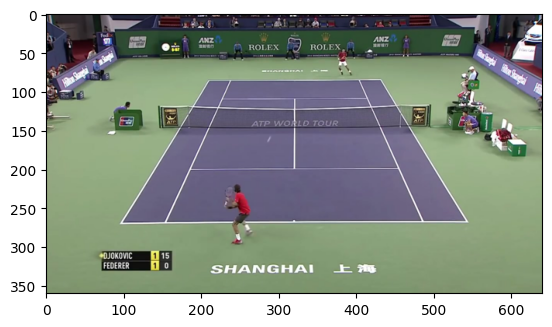

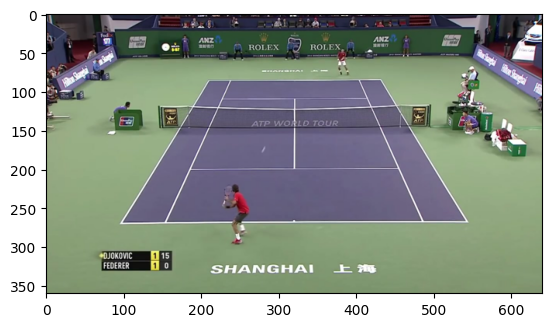

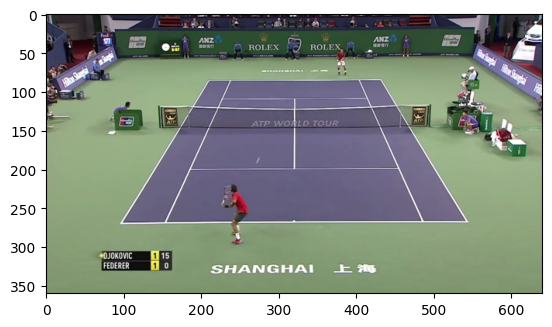

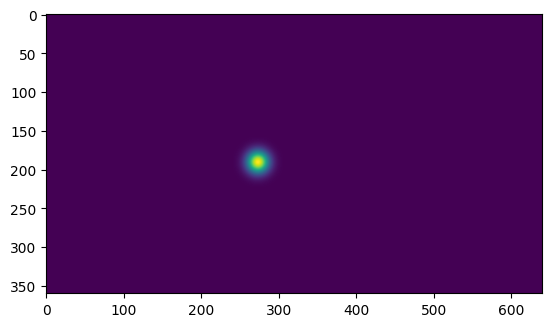

In [10]:
import matplotlib.pyplot as plt

stack_s = 3
train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
stack, mask = train_gen.get_random_stack()
print(stack.shape, mask.shape)

for i in range(stack_s):
    plt.figure()
    plt.imshow(stack[:, :, 3 * i: 3 * i + 3])
plt.figure()
plt.imshow(mask)

In [11]:
class Metrics:

    @staticmethod
    def position_error(label_gt: np.ndarray, label_pr: np.ndarray, step=8, alpha=1.5, e1=5, e2=5):
        # gt codes:
        # 0 - the ball is not within the image
        # 1 - the ball can easily be identified
        # 2 - the ball is in the frame, but is not easy to identify
        # 3 - the ball is occluded
        if label_gt[0] != 0 and label_pr[0] == 0:
            return e1
        if label_gt[0] == 0 and label_pr[0] != 0:
            return e2
        dist = math.sqrt((label_gt[1] - label_pr[1]) ** 2 + (label_gt[2] - label_pr[2]) ** 2)
        pe = math.floor(dist / step) ** alpha
        pe = min(pe, 5)
        return pe

    @staticmethod
    def evaluate_predictions(labels_gt, labels_pr) -> Tuple[List[float], float]:
        pe = [Metrics.position_error(labels_gt[i, ...], labels_pr[i, ...]) for i in range(len(labels_gt))]
        SIBATRACC = []
        for i, _ in enumerate(pe):
            SIBATRACC.append(1 - sum(pe[: i + 1]) / ((i + 1) * 5))
        SIBATRACC_total = 1 - sum(pe) / (len(labels_gt) * 5)
        return SIBATRACC, SIBATRACC_total

In [12]:
import tensorflow as tf

def calculate_intersection_and_union(y_true, y_pred):
    """
    Calculates the intersection and union of the flattened true and predicted values.
    """
    y_true_fl = tf.reshape(y_true, [-1])  # Flatten tensor
    y_pred_fl = tf.reshape(y_pred, [-1])  # Flatten tensor
    intersection = tf.reduce_sum(y_true_fl * y_pred_fl)
    union = tf.reduce_sum(y_true_fl + y_pred_fl) - intersection
    return intersection, union

def IoU(y_true, y_pred):
    """
    Computes the Intersection over Union (IoU) metric.
    """
    intersection, union = calculate_intersection_and_union(y_true, y_pred)
    return intersection / (union + tf.keras.backend.epsilon())  # Add epsilon for numerical stability

def IoU_loss(y_true, y_pred):
    """
    Computes the IoU loss, defined as 1 - IoU.
    """
    return 1 - IoU(y_true, y_pred)

In [13]:
class SuperTrackingModel:

    def __init__(self, batch_s, stack_s, out_path, downscale):
        # Initialize the model with required parameters
        self.batch_s = batch_s
        self.stack_s = stack_s
        self.out_path = out_path
        self.downscale = downscale
        self.model = self.UNet()  # Create the UNet model

    def load(self):
        # Load the pre-trained model weights
        print('Running stub for loading model ...')
        id = '1el6uwAe43q4pnZeDHTuTsj0Jy565P23N'
        url = f'https://drive.google.com/uc?id={id}'  # URL to download model weights
        output = 'loaded_weights.h5'
        gdown.download(url, output, quiet=False)  # Download the model weights
        self.model.load_weights("/kaggle/working/loaded_weights.h5")  # Load the weights into the model
        print('Loading model done.')
    
    def predict_on_batch(self, batch: np.ndarray) -> np.ndarray:
        # Predict on a batch of input data
        predictions = self.model.predict(batch)
        return predictions.reshape(self.batch_s, 360, 640)  # Reshape the predictions to fit the output shape
        
    def _predict_prob_on_clip(self, clip: np.ndarray) -> np.ndarray:
        # Perform prediction on a video clip
        print('doing predictions')
        n_frames = clip.shape[0]
        # Prepare stacks of frames
        stacks = []
        for i in range(n_frames - self.stack_s + 1):
            stack = clip[i : i + self.stack_s, ...]
            stack = np.squeeze(np.split(stack, self.stack_s, axis=0))
            stack = np.concatenate(stack, axis=-1)
            stacks.append(stack)
        # Adjust the stack list to match the batch size
        add_stacks = 0
        while len(stacks) % self.batch_s != 0:
            stacks.append(stacks[-1])
            add_stacks += 1
        # Group the stacks into batches
        batches = []
        for i in range(len(stacks) // self.batch_s):
            batch = np.stack(stacks[i * self.batch_s : (i + 1) * self.batch_s])
            batches.append(batch)
        stacks.clear()  # Clear the stacks list as batches are ready
        # Perform the predictions on batches
        predictions = []
        for batch in batches:
            pred = np.squeeze(self.predict_on_batch(batch))
            predictions.append(pred)
        # Crop predictions to match the original clip length
        predictions = np.concatenate(predictions, axis=0)
        if (add_stacks > 0):
            predictions = predictions[:-add_stacks, ...]
        batches.clear()  # Clear the batches list
        # Add null frames at the beginning of the predictions
        start_frames = np.zeros((self.stack_s - 1, predictions.shape[1], predictions.shape[2]), dtype=np.float32)
        predictions = np.concatenate((start_frames, predictions), axis=0)
        print('predictions are made')        
        return predictions

    def get_labels_from_prediction(self, pred_prob: np.ndarray, upscale_coords: bool) -> np.ndarray:
        # Convert prediction probabilities to labels
        n_frames = pred_prob.shape[0]
        coords = np.zeros([n_frames, 3])
        for i in range(n_frames):
            mask = pred_prob[i]
            x, y = mask.sum(axis=0).argmax(), mask.sum(axis=1).argmax()  # Find the ball's coordinates
            ball_h, ball_w = mask.sum(axis=0).max(), mask.sum(axis=1).max()  # Get ball's height and width
            code = 0 if (ball_h < 5) or (ball_w < 5) else 1  # Classify as ball or not based on size
            if upscale_coords:
                x, y = x * 2, y * 2  # Upscale the coordinates if needed
            coords[i] = [code, x, y]
        return coords

    def postprocess_labels(self, labels):
        # Post-process labels to remove outliers and smooth the coordinates
        index_x, index_y = [0], [0]
        x, y = [labels[0][1]], [labels[0][2]]
        for i in range(1, len(labels)-1):
            if labels[i][0] == 0 and labels[i-1][0] == 1 and labels[i+1][0] == 1:
                labels[i][0] = 1
            if labels[i][0] == 1:
                # Check if there is a large deviation in x or y coordinates and correct it
                if abs(labels[i][1] - labels[i-1][1]) < 50 or abs(labels[i][1] - labels[i+1][1]) < 50:
                    index_x.append(i)
                    x.append(labels[i][1])
                if abs(labels[i][2] - labels[i-1][2]) < 50 or abs(labels[i][2] - labels[i+1][2]) < 50:
                    index_y.append(i)
                    y.append(labels[i][2])
        index_x.append(len(labels)-1)
        index_y.append(len(labels)-1)
        x.append(labels[len(labels)-1][1])
        y.append(labels[len(labels)-1][2])
        # Interpolate missing values
        x = interp1d(index_x, x)
        y = interp1d(index_y, y)
        index_x = list(filter(lambda x: x not in index_x, list(range(len(labels)))))
        index_y = list(filter(lambda y: y not in index_y, list(range(len(labels)))))
        # Fill in the missing coordinates with interpolated values
        for i in index_x:
            labels[i][1] = float(int(x(i)))
        for i in index_y:
            labels[i][2] = float(int(y(i)))
        return labels

    def predict(self, clip: np.ndarray, upscale_coords=True) -> np.ndarray:
        # Predict labels and probabilities for a video clip
        prob_pr = self._predict_prob_on_clip(clip)
        labels_pr = self.get_labels_from_prediction(prob_pr, upscale_coords)
        labels = self.postprocess_labels(labels_pr)
        return labels, prob_pr

    def test(self, data_path: Path, games: List[int], do_visualization=False, test_name='test'):
        # Evaluate the model on test data
        game_clip_pairs = get_game_clip_pairs(data_path, games)
        SIBATRACC_vals = []
        for game, clip in game_clip_pairs:
            data = load_clip_data(data_path, game, clip, downscale=self.downscale)
            if do_visualization:
                # Load full data for visualization if required
                data_full = load_clip_data(data_path, game, clip, downscale=False) if self.downscale else data
            labels_gt = load_clip_labels(data_path, game, clip, downscale=False)  # Load ground truth labels
            labels_pr, prob_pr = self.predict(data)  # Get predictions
            SIBATRACC_per_frame, SIBATRACC_total = Metrics.evaluate_predictions(labels_gt, labels_pr)
            SIBATRACC_vals.append(SIBATRACC_total)  # Calculate and store evaluation metrics
            if do_visualization:
                # Visualize predictions and probabilities if required
                visualize_prediction(data_full, labels_pr, self.out_path, f'{test_name}_g{game}_c{clip}', SIBATRACC_per_frame)
                visualize_prob(data, prob_pr, self.out_path, f'{test_name}_g{game}_c{clip}')
                del data_full
            del data, labels_gt, labels_pr, prob_pr
            gc.collect()  # Free memory
        SIBATRACC_final = sum(SIBATRACC_vals) / len(SIBATRACC_vals)  # Calculate final score
        return SIBATRACC_final
    
    def UNet(self):
        # Define the architecture of the UNet model
        def double_conv_block(x, n_filters):
            # Two convolution layers with batch normalization
            conv = layers.Conv2D(n_filters, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
            conv = layers.BatchNormalization()(conv)
            conv = layers.Conv2D(n_filters, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(1e-4))(conv)
            conv = layers.BatchNormalization()(conv)
            return conv

        def downsample_block(x, n_filters):
            # Downsampling block with convolution and max-pooling
            conv = double_conv_block(x, n_filters)
            pool = layers.MaxPooling2D((2, 2))(conv)
            pool = layers.Dropout(0.3)(pool)  # Dropout for regularization
            return conv, pool
        
        def upsample_block(x, conv, n_filters_transpose, n_filters_conv):
            # Upsampling block with transposed convolution and concatenation
            up = layers.Conv2DTranspose(n_filters_transpose, (3, 3), strides=(2, 2), padding="same")(x)
            up = layers.concatenate([up, conv])
            up = layers.Dropout(0.3)(up)
            conv = double_conv_block(up, n_filters_conv)
            return conv
        
        inputs = keras.Input(shape=(360, 640, 15))  # Input shape for the model
        
        # Encoding path (downsampling)
        conv1, pool1 = downsample_block(inputs, 32)
        conv2, pool2 = downsample_block(pool1, 64)
        conv3, pool3 = downsample_block(pool2, 64)
        
        # Bottleneck (bottleneck layer before upsampling)
        bottleneck4 = double_conv_block(pool3, 128)
        
        # Decoding path (upsampling)
        up5 = upsample_block(bottleneck4, conv3, 32, 64)
        up6 = upsample_block(up5, conv2, 16, 64)
        up7 = upsample_block(up6, conv1, 8, 32)
        
        # Output layer with sigmoid activation for binary classification
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(up7)

        return keras.Model(inputs=[inputs], outputs=[outputs])  # Return the model

    def train(self, train, val):
        # Train the model on the given data
        print('Starting training...')
        self.model.compile(Adam(learning_rate=4e-4), loss=IoU_loss, metrics=[IoU])  # Compile the model
        file_path_best = "/kaggle/working/exp_1/model_weights_best.weights.h5"
        
        # Define checkpoint to save the best model based on validation loss
        modelcheckpoint_best = keras.callbacks.ModelCheckpoint(file_path_best,
                                                               monitor='val_loss',
                                                               mode='auto',
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=True)
        
        # Train the model with the provided data
        self.history = self.model.fit(train(self.batch_s),
                                      steps_per_epoch=150,
                                      epochs=20,
                                      callbacks=[modelcheckpoint_best],
                                      validation_data=val(self.batch_s),
                                      validation_steps=50)
        print('Training completed.')

In [14]:
batch_s = 4
stack_s = 5
downscale = True

output_path = prepare_experiment(Path('/kaggle/working'))

model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=downscale)

In [15]:
train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1, 2, 3, 4, 5, 6], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=True)
val_gen = DataGenerator(Path('../input/tennistrackingassignment/test/'), [1, 2], stack_s=stack_s, downscale=True, pool_s=4, pool_update_s=2, quiet=True)

In [16]:
model.train(train_gen.random_g, val_gen.random_g)

Starting training...
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - io_u: 0.0040 - loss: 1.1257
Epoch 1: val_loss improved from inf to 1.04894, saving model to /kaggle/working/exp_1/model_weights_best.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 144ms/step - io_u: 0.0040 - loss: 1.1255 - val_io_u: 0.0021 - val_loss: 1.0489
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - io_u: 0.0121 - loss: 1.0322
Epoch 2: val_loss improved from 1.04894 to 0.99575, saving model to /kaggle/working/exp_1/model_weights_best.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - io_u: 0.0122 - loss: 1.0321 - val_io_u: 0.0364 - val_loss: 0.9958
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - io_u: 0.0667 - loss: 0.9644
Epoch 3: val_loss improved from 0.99575 to 0.86638, saving model to /kaggle/working/exp_1/model_weights_best.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - io_u: 0.0669 - loss: 0.9643 - val_io_u: 0.1654 - val_loss: 0.8664
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━

In [17]:
batch_s = 4
stack_s = 5
downscale = True
output_path = prepare_experiment(Path('/kaggle/working'))
new_model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=downscale)
new_model.load()
sibatracc_final = new_model.test(Path('../input/tennistrackingassignment/test/'), [1,2], do_visualization=True, test_name='test')
print(f'SiBaTrAcc final value: {sibatracc_final}')

Running stub for loading model ...


Downloading...
From: https://drive.google.com/uc?id=1el6uwAe43q4pnZeDHTuTsj0Jy565P23N
To: /kaggle/working/loaded_weights.h5
100%|██████████| 2.58M/2.58M [00:00<00:00, 219MB/s]


Loading model done.
loading clip data (game 1, clip 1) downscaled
loading clip data (game 1, clip 1) 
loading clip labels (game 1, clip 1)
doing predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━